In [1]:
import argparse
import numpy as np
import torch
import torch.nn as nn

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['savefig.dpi'] = 300

import sys
sys.path.append("..")
from utilities import *
from torch_symplectic_adjoint import odeint_symplectic_adjoint as odeint

# Lorenz system
We demonstrate our method on the nonlinear Lorenz system:
\begin{equation*}
\begin{aligned}
&\dot x = \sigma(y-x),\\
&\dot y = x(\rho - z) - y,\\
&\dot z = xy - \beta z.
\end{aligned}    
\end{equation*}
The dynamics are very rich for different choices of parameters $(\sigma,\rho,\beta)$. The well-known Lorenz attractor shows up for $(\sigma,\rho,\beta)=(10, 28, 8/3)$.
For this example, the neural network $G$ used to approximate $f$ has $3$ hidden layers of $300$ neurons.

# Generalization performance
This experiment test the generalization performance of OCN by applying it to initial points that are different from the initial points used in training. We consider a unit ball $S = \{u\;|\;\|u-x_0\|\leq 1\}$ where $x_0=[10, 15, 17]$. The training data consists of 3 trajectories with the initial points in $S$, time interval $[0, 3]$, and time step $\Delta t=0.01$.

In [2]:
def get_parser():
    parser = argparse.ArgumentParser('Lorenz system')
    parser.add_argument('--model_true', type=str, choices=['LGF', 'NGF', 'Pendulum', 'Lorenz'], default='Lorenz')
    parser.add_argument('--model_ocn', type=str, choices=['OCN', 'OCN_GF'], default='OCN')
    parser.add_argument('--x0', nargs='+', default=[0., 0., 0.])
    parser.add_argument('--train_time', type=float, default=3)
    parser.add_argument('--step_size', type=int, default=0.01)
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--test_time', type=int, default=3)
    parser.add_argument('--hidden_layers', type=int, default=3)
    parser.add_argument('--hidden_neurons', type=int, default=300)
    return parser

In [3]:
parser = get_parser()
args = parser.parse_args("")
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
ckpt = torch.load('checkpoint/pretrained/Lorenz-G3x300-T3.0-bs2', map_location=torch.device('cpu'))

In [4]:
model_true = eval(args.model_true)
model_ocn = eval(args.model_ocn)
y0 = initial_point(args, device)

trf = model_true()
ocn = model_ocn(args)
ocn.load_state_dict(ckpt['params'])

true_y_train, train_t = build_dataset(args, model_true=model_true, data_type='train', y0=y0, device=device)
pred_y_train = odeint(ocn, y0, train_t, method="dopri5")

train_tt = train_t.cpu().numpy()
true_train_yy = true_y_train.cpu().detach().numpy()
pred_train_yy = pred_y_train.cpu().detach().numpy()

In [26]:
true_test_yy.shape

(301, 6, 3)

## Training reults

In [34]:
def plot_loss(true_y, pred_y, idx):
    if true_y.shape[1] == 3:
        type = "Training"
    else:
        type = "Testing"
        
    loss = np.mean((true_y[:, idx, :] - pred_y[:, idx, :])**2)

    fig = plt.figure(1, figsize=(4,4)).add_subplot(projection='3d')
    fig.plot3D(true_y[:, idx, 0], true_y[:, idx, 1], true_y[:, idx, 2], 'b-', label = 'true')
    fig.plot3D(pred_y[:, idx, 0], pred_y[:, idx, 1], pred_y[:, idx, 2], 'c--', label = 'pred')
    fig.set_title('{} loss = {:.2f}'.format(type, loss))
    fig.set_xlabel(r'$x$')
    fig.set_ylabel(r'$y$')
    fig.legend()
    plt.tight_layout()

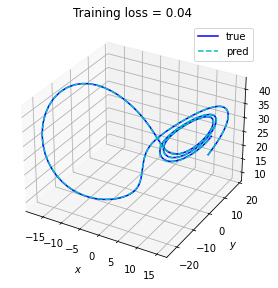

In [29]:
plot_loss(true_train_yy, pred_train_yy, 0)

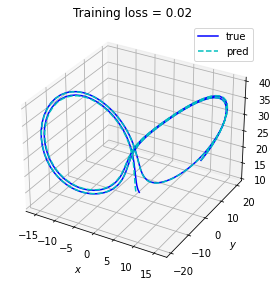

In [30]:
plot_loss(true_train_yy, pred_train_yy, 1)

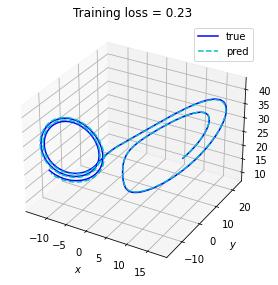

In [31]:
plot_loss(true_train_yy, pred_train_yy, 2)

## Test results
After training, we randomly select 300 points from $S$ as initial points. For each initial point, we generate the true trajectory data and the prediction by OCN, then compute the loss. Below is the histogram of loss over 300 trajectories.

In [9]:
# Define the center of the ball
center = np.array([0., 0., 0.])
npoints = 300

# Sample points until we have 300 points inside the unit ball
points = []
while len(points) < npoints:
    # Generate a random point in the cube [-1, 1]^3
    point = 2 * np.random.rand(3) - 1
    
    # If the point is inside the unit ball, add it to the list of points
    if np.linalg.norm(point - center) <= 1:
        points.append(point)

# Convert the list of points to a numpy array
points = np.array(points) + np.array([10., 15., 17.])

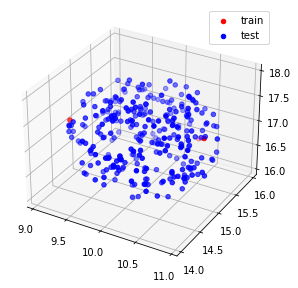

In [11]:
fig = plt.figure(1, figsize=(4,4)).add_subplot(projection='3d')
fig.scatter(y0[:,0], y0[:,1], y0[:,2], c='r', label='train')
fig.scatter(points[:,0], points[:,1], points[:,2], c='b', label='test')
plt.legend()
plt.tight_layout()

In [ ]:
losses = []
for i in range(npoints):
    y0 = [float(j) for j in points[i]]
    
    true_y_train, train_t = build_dataset(args, data_type='train', y0=torch.tensor([y0]))
    pred_y_train = odeint(ocn, torch.tensor([y0]).to(device), train_t, method="dopri5")
    
    loss = torch.mean((true_y_train - pred_y_train)**2).item()
    if i % 30 == 0:
        print("[{}]: {} ".format(i, loss))
    losses.append(loss)

In [12]:
# load losses that generate the plot presented in the paper
losses = np.load('output/T3_losses.npy')

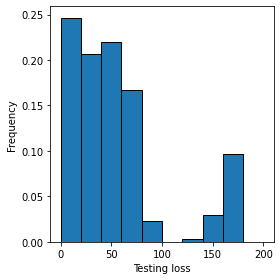

In [13]:
plt.figure(figsize=(4, 4))
plt.hist(losses, weights=np.ones_like(losses) / len(losses), range=(0,200), edgecolor='black')
plt.xlabel('Testing loss')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.savefig('output/T3_hist', dpi=300)

We see that the loss is less than $80$ in over $80\%$ cases. Below we present trajectories generated by $6$ different initial points, each corresponding to a different loss. 

In [15]:
test_y0 = np.load('output/T3_initial_points_test.npy')
test_y0 = torch.tensor(test_y0).to(device)

true_y_test, test_t = build_dataset(args, model_true=model_true, data_type='test', y0=test_y0, device=device)
pred_y_test = odeint(ocn, test_y0, test_t, method="dopri5")

test_tt = test_t.cpu().numpy()
true_test_yy = true_y_test.cpu().detach().numpy()
pred_test_yy = pred_y_test.cpu().detach().numpy()

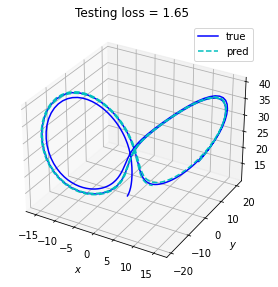

In [35]:
plot_loss(true_test_yy, pred_test_yy, 0)

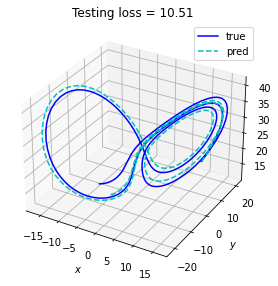

In [36]:
plot_loss(true_test_yy, pred_test_yy, 1)

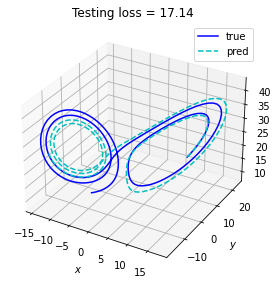

In [37]:
plot_loss(true_test_yy, pred_test_yy, 2)

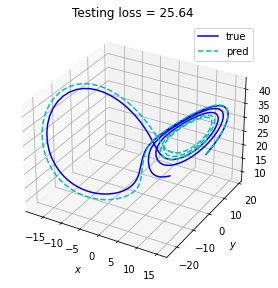

In [38]:
plot_loss(true_test_yy, pred_test_yy, 3)

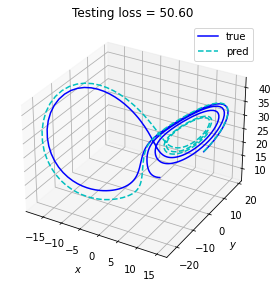

In [39]:
plot_loss(true_test_yy, pred_test_yy, 4)

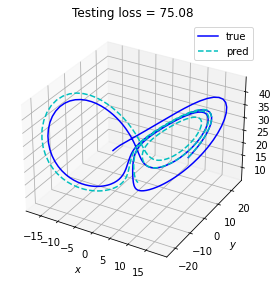

In [40]:
plot_loss(true_test_yy, pred_test_yy, 5)

Overall, OCN shows reasonably good prediction performance on data that is close to but does not belong to the training data.

# Short-time performance 
In this case, the data used to train OCN is collected from $1$ trajectory with the initial point $[10, 15, 17]$, time interval $[0,1.5]$, and time step $\Delta t=0.01$. After the model is well trained, we apply it to generate trajectories on time interval $[0, 3]$ with the same initial point. 

In [12]:
def get_parser():
    parser = argparse.ArgumentParser('Lorenz system')
    parser.add_argument('--model_true', type=str, choices=['LGF', 'NGF', 'Pendulum', 'Lorenz'], default='Lorenz')
    parser.add_argument('--model_ocn', type=str, choices=['OCN', 'OCN_GF'], default='OCN')
    parser.add_argument('--x0', nargs='+', default=[10., 15., 17.])
    parser.add_argument('--train_time', type=float, default=1.5)
    parser.add_argument('--step_size', type=int, default=0.01)
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--test_time', type=int, default=3)
    parser.add_argument('--hidden_layers', type=int, default=3)
    parser.add_argument('--hidden_neurons', type=int, default=300)
    return parser

In [13]:
parser = get_parser()
args = parser.parse_args("")
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
ckpt = torch.load('checkpoint/pretrained/Lorenz-G3x300-T1.5-bs2', map_location=torch.device('cpu'))

In [14]:
model_true = eval(args.model_true)
model_ocn = eval(args.model_ocn)
test_y0 = initial_point(args, device)

trf = model_true()
ocn = model_ocn(args)
ocn.load_state_dict(ckpt['params'])

true_y_test, test_t = build_dataset(args, model_true=model_true, data_type='test', y0=test_y0, device=device)
pred_y_test = odeint(ocn, test_y0, test_t, method="dopri5")

test_tt = test_t.cpu().numpy()
true_test_yy = true_y_test.cpu().detach().numpy()
pred_test_yy = pred_y_test.cpu().detach().numpy()

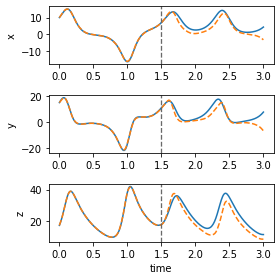

In [15]:
fig = plt.figure(figsize=(4, 4))

ax = fig.add_subplot(311)
ax.plot(test_tt, true_test_yy[:, 0, 0], '-', label=r'true')
ax.plot(test_tt, pred_test_yy[:, 0, 0], '--',label=r'pred')
ax.axvline(x=1.5, color='dimgrey', linewidth=1.3, linestyle='--')
plt.ylabel("x")

ax = fig.add_subplot(312)
ax.plot(test_tt, true_test_yy[:, 0, 1], '-', label=r'true')
ax.plot(test_tt, pred_test_yy[:, 0, 1], '--', label=r'pred')
ax.axvline(x=1.5, color='dimgrey', linewidth=1.3, linestyle='--')
plt.ylabel("y")

ax = fig.add_subplot(313)
ax.plot(test_tt, true_test_yy[:, 0, 2], '-', label=r'true')
ax.plot(test_tt, pred_test_yy[:, 0, 2], '--', label=r'pred')
ax.axvline(x=1.5, color='dimgrey', linewidth=1.3, linestyle='--')
plt.xlabel("time")
plt.ylabel("z")

plt.tight_layout()

In [8]:
np.mean((true_test_yy-pred_test_yy)**2)

6.929186

# Long-time performance
The data used for training OCN is collected from $1$ trajectory starting from $[-8, 8, 27]$, with time interval $[0,20]$ and time step $\Delta t=0.01$. 

In [16]:
def get_parser():
    parser = argparse.ArgumentParser('Lorenz system')
    parser.add_argument('--model_true', type=str, choices=['LGF', 'NGF', 'Pendulum', 'Lorenz'], default='Lorenz')
    parser.add_argument('--model_ocn', type=str, choices=['OCN', 'OCN_GF'], default='OCN')
    parser.add_argument('--x0', nargs='+', default=[-8., 8., 27.])
    parser.add_argument('--train_time', type=float, default=20)
    parser.add_argument('--step_size', type=int, default=0.01)
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--test_time', type=int, default=0)
    parser.add_argument('--hidden_layers', type=int, default=3)
    parser.add_argument('--hidden_neurons', type=int, default=300)
    return parser

In [17]:
parser = get_parser()
args = parser.parse_args("")
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
ckpt = torch.load('checkpoint/pretrained/Lorenz-G3x300-T20.0-bs2', map_location=torch.device('cpu'))

In [18]:
model_true = eval(args.model_true)
model_ocn = eval(args.model_ocn)
y0 = initial_point(args, device)

trf = model_true()
ocn = model_ocn(args)
ocn.load_state_dict(ckpt['params'])

true_y_train, train_t = build_dataset(args, model_true=model_true, data_type='train', y0=y0, device=device)
pred_y_train = odeint(ocn, y0, train_t, method="dopri5")

train_tt = train_t.cpu().numpy()
true_train_yy = true_y_train.cpu().detach().numpy()
pred_train_yy = pred_y_train.cpu().detach().numpy()

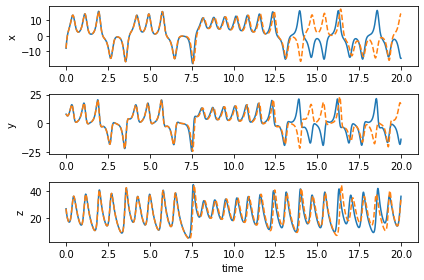

In [19]:
fig = plt.figure(figsize=(6, 4))

ax = fig.add_subplot(311)
ax.plot(train_tt, true_train_yy[:, 0, 0], '-', label=r'true')
ax.plot(train_tt, pred_train_yy[:, 0, 0], '--', label=r'pred')
plt.ylabel("x")

ax = fig.add_subplot(312)
ax.plot(train_tt, true_train_yy[:, 0, 1], '-', label=r'true')
ax.plot(train_tt, pred_train_yy[:, 0, 1], '--', label=r'pred')
plt.ylabel("y")

ax = fig.add_subplot(313)
ax.plot(train_tt, true_train_yy[:, 0, 2], '-', label=r'true')
ax.plot(train_tt, pred_train_yy[:, 0, 2], '--', label=r'pred')
plt.xlabel("time")
plt.ylabel("z")

plt.tight_layout()

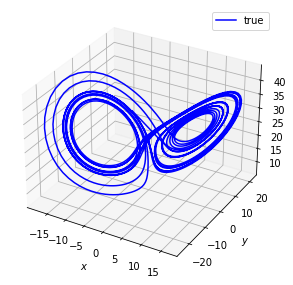

In [20]:
fig = plt.figure(1, figsize=(5,4)).add_subplot(projection='3d')
fig.plot3D(true_train_yy[:, 0, 0], true_train_yy[:, 0, 1], true_train_yy[:, 0, 2], 'b-', label = 'true')
fig.set_xlabel(r'$x$')
fig.set_ylabel(r'$y$')
fig.legend()
plt.tight_layout()

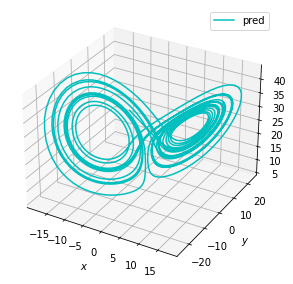

In [21]:
fig = plt.figure(1, figsize=(5,4)).add_subplot(projection='3d')
fig.plot3D(pred_train_yy[:, 0, 0], pred_train_yy[:, 0, 1], pred_train_yy[:, 0, 2], 'c-', label = 'pred')
fig.set_xlabel(r'$x$')
fig.set_ylabel(r'$y$')
fig.legend()

plt.tight_layout()

In [22]:
np.mean((true_train_yy-pred_train_yy)**2)

44.77337